# CreditNinja Modeling Challenge

In this case study, we are asking you to review a dataset, clean the dataset, and then provide us with your thoughts regarding 1) which business rules can be used to reduce default rate, and 2) how a model could be built to effectively predict a potential borrower’s chance of default.

In [1]:
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Notebook Last Run Initiated: 2020-10-06 08:57:30.282563


## Standard Python Modules

In [357]:
from numpy import reshape
from pandas import DataFrame, Series, to_datetime
import xgboost
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score    
from sklearn.feature_selection import SelectFromModel
from transform import transformData
from traintest import trainEstimator

import sys
print(sys.version)

3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


# Model Inputs

In [3]:
from pandas import read_csv
data = read_csv("ModelingChallenge/data.csv")
data.describe()

,id,loan_amnt,installment,annual_inc,dti,fico_range_low,fico_range_high,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m
count,8.000000e+04,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,41786.000000,14532.000000,80000.000000,37395.000000
mean,6.474229e+07,15055.793750,443.595158,7.778995e+04,19.446568,694.314000,698.314112,693.328225,686.068437,0.006488,16.692025,0.352275,33.964558,66.776356,0.565950,2.184009
std,1.488143e+07,8729.299624,255.693326,8.648673e+04,61.871127,30.744603,30.745156,58.631248,79.416694,0.084235,848.289643,0.942411,21.997469,25.205219,0.863342,2.473969
min,6.510400e+04,1000.000000,30.120000,0.000000e+00,0.000000,660.000000,664.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.389471e+07,8000.000000,258.100000,4.700000e+04,12.430000,670.000000,674.000000,669.000000,665.000000,0.000000,0.000000,0.000000,15.000000,50.000000,0.000000,0.000000
50%,6.571584e+07,13275.000000,382.500000,6.500000e+04,18.440000,685.000000,689.000000,699.000000,695.000000,0.000000,0.000000,0.000000,31.000000,68.000000,0.000000,1.000000
75%,7.612197e+07,20000.000000,585.080000,9.250000e+04,25.170000,710.000000,714.000000,729.000000,725.000000,0.000000,0.000000,0.000000,50.000000,83.000000,1.000000,3.000000
max,9.094516e+07,40000.000000,1536.950000,8.706582e+06,9999.000000,845.000000,850.000000,850.000000,845.000000,3.000000,110626.000000,39.000000,146.000000,119.000000,6.000000,36.000000


In [4]:
data.columns

Index(['id', 'loan_amnt', 'term', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'addr_state', 'dti', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'acc_now_delinq',
       'delinq_amnt', 'delinq_2yrs', 'mths_since_last_delinq',
       'mths_since_last_record', 'inq_last_6mths', 'inq_last_12m'],
      dtype='object')

In [5]:
data['loan_status'].value_counts()

Current       62429
Fully Paid    11534
Default        6037
Name: loan_status, dtype: int64

# Question 1

### I am going to pursue the binary classification approach. I believe that this technique versus the multi-class classification will allow for increased statistical power (i.e., more training data) to isolate those nearing default from the 62k 'Current' population.

In [10]:
#### Isolate the testing/training dataset. We can only use the 
#### data with defined labels in the binary-classification approach
testtrainData = data[data['loan_status'].isin(['Fully Paid', 'Default'])].copy(deep=True)

In [19]:
def label(x):
    if x == "Default":
        return 1
    elif x == "Fully Paid":
        return 0
    else:
        raise ValueError("Unknown entry in the labeled dependent data")
y = testtrainData['loan_status'].apply(label) ## y is the dependent data also known as the target variable

In [433]:
## X is the predictor data also known collectively as the feature dataset
X = testtrainData.drop(['loan_status'], axis=1)

In [434]:
X.columns

Index(['id', 'loan_amnt', 'term', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'last_credit_pull_d', 'last_fico_range_high',
       'last_fico_range_low', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'inq_last_6mths',
       'inq_last_12m'],
      dtype='object')

In [435]:
X.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,...,last_credit_pull_d,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m
3,54027458,14000,36 months,439.88,5 years,RENT,50000.0,Source Verified,Jul-2015,debt_consolidation,...,Oct-2016,749,745,0,0,0,NaN,42.0,0,NaN
4,72594974,7500,36 months,252.67,3 years,MORTGAGE,68000.0,Not Verified,Feb-2016,debt_consolidation,...,Dec-2016,709,705,0,0,0,NaN,NaN,2,5.0
6,71061534,25000,36 months,870.44,5 years,RENT,55000.0,Verified,Feb-2016,other,...,Nov-2016,759,755,0,0,0,NaN,NaN,1,3.0
7,54474095,12000,36 months,382.55,5 years,RENT,30000.0,Not Verified,Jul-2015,debt_consolidation,...,Oct-2015,749,745,0,0,0,NaN,NaN,0,NaN
21,45704513,30000,60 months,677.85,10+ years,RENT,84000.0,Verified,Apr-2015,debt_consolidation,...,Oct-2016,669,665,0,0,0,NaN,NaN,0,NaN


# Question 2

In [436]:
# There are several categorical variables that require encoding to be useful in a machine learning model.
# There are also several variables with NaN or other non-numeric, non-categorical data that must be cleaned.

In [437]:
## Notes: I suppose defaulting on a larger loan is much worse than defaulting on a small loan.
## Perhaps the multi-class approach is worth considering...

In [438]:
## Will clean the data column by column

## Find out where the NAs are

In [439]:
for col in X:
    if sum(X[col].isna()) > 0:
        print(col,"Has NA")

emp_length Has NA
mths_since_last_delinq Has NA
mths_since_last_record Has NA
inq_last_12m Has NA


## Found out where the Categorical variables are

In [440]:
## Need to encode the following columns (if we want to use them)
X.columns[X.dtypes == 'object']

Index(['term', 'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'purpose', 'addr_state', 'earliest_cr_line',
       'last_credit_pull_d'],
      dtype='object')

In [441]:
replacementData = {}

#### Term

In [442]:
print(X['term'].value_counts())
le = preprocessing.LabelEncoder()
retval = X[['term']].apply(le.fit_transform)
replacementData["term"] = retval.copy(deep=True)

36 months    12281
60 months     5290
Name: term, dtype: int64


#### emp_length

In [443]:
## Employment length is really an ordered variable. Will return it to it's numerical state.
## For the missing employment data, I will try a few different things including an indicator variable

In [444]:
def isEmploymentLengthNA(x):
    if isinstance(x, float):
        return 1
    return 0
def getEmploymentLength(x):
    ## Returning mean of employment distribution if missing data
    ## The mean appears to be 6.07 years.
    if isinstance(x, str):
        tmp = x.replace("+", "").strip()
        tmp = tmp.replace("<", "").strip()
        tmp = tmp.split(" ")[0]
        return float(tmp)
    else:
        return 6.07

emp_length    = X['emp_length'].apply(getEmploymentLength)
emp_length_na = X['emp_length'].apply(isEmploymentLengthNA)
retval = DataFrame([emp_length_na, emp_length]).T   
retval.columns = ["emp_length_NA", "emp_length"]
replacementData["emp_length"] = retval.copy(deep=True)

#### home_ownership

In [445]:
print(X['home_ownership'].value_counts())
le = preprocessing.LabelEncoder()
leX = X[['home_ownership']].apply(le.fit_transform)
enc = preprocessing.OneHotEncoder()
enc.fit(leX)
onehotlabels = enc.transform(leX)
colnames = ["home_ownership_{0}".format(val.replace(" ", "")) for val in list(le.classes_)]
encdata = DataFrame(onehotlabels.toarray())
encdata.columns = colnames
replacementData["home_ownership"] = encdata.copy(deep=True)

MORTGAGE    8710
RENT        6841
OWN         2020
Name: home_ownership, dtype: int64


#### verification_status

In [446]:
print(X['verification_status'].value_counts())
le = preprocessing.LabelEncoder()
leX = X[['verification_status']].apply(le.fit_transform)
enc = preprocessing.OneHotEncoder()
enc.fit(leX)
onehotlabels = enc.transform(leX)
colnames = ["verification_status_{0}".format(val.replace(" ", "")) for val in list(le.classes_)]
encdata = DataFrame(onehotlabels.toarray())
encdata.columns = colnames
replacementData["verification_status"] = encdata.copy(deep=True)

Source Verified    7361
Verified           5627
Not Verified       4583
Name: verification_status, dtype: int64


#### purpose

In [447]:
## will likely need to consolidate some of the categories given the statistics
## I am going to consolidate everything below 1000 into a new other category

In [448]:
extra = ['major_purchase', 'medical', 'small_business', 'car', 'moving', 'vacation', 'house', 'renewable_energy', 'wedding']
X['purpose'][X['purpose'].isin(extra)] = 'extra'
X['purpose']

/Users/tgadfort/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


3        debt_consolidation
4        debt_consolidation
6                     other
7        debt_consolidation
21       debt_consolidation
                ...        
79970           credit_card
79975                 other
79976    debt_consolidation
79983                 other
79991                 extra
Name: purpose, Length: 17571, dtype: object

In [449]:
print(X['purpose'].value_counts())
le = preprocessing.LabelEncoder()
leX = X[['purpose']].apply(le.fit_transform)
enc = preprocessing.OneHotEncoder()
enc.fit(leX)
onehotlabels = enc.transform(leX)
colnames = ["purpose_{0}".format(val.replace(" ", "")) for val in list(le.classes_)]
encdata = DataFrame(onehotlabels.toarray())
encdata.columns = colnames
replacementData["purpose"] = encdata.copy(deep=True)

debt_consolidation    10761
credit_card            3354
extra                  1326
home_improvement       1098
other                  1032
Name: purpose, dtype: int64


#### earliest_cr_line, last_credit_pull_d, issue_d

In [450]:
## These is really a temporal variable. Will need to convert it into something usable.

In [451]:
from pandas import to_datetime
X['earliest_cr_line'] = to_datetime(X['earliest_cr_line'])
X['last_credit_pull_d'] = to_datetime(X['last_credit_pull_d'])
X['issue_d'] = to_datetime(X['issue_d'])

nowDate = to_datetime('01/23/2017')
def getDays(val):
    return val.days

X['time_since_first_credit'] = (nowDate - X['earliest_cr_line']).apply(getDays)
X['time_since_credit_pull'] = (nowDate - X['last_credit_pull_d']).apply(getDays)
X['time_since_credit_issue'] = (X['last_credit_pull_d'] - X['issue_d']).apply(getDays)
X.drop(['earliest_cr_line', 'last_credit_pull_d', 'issue_d'], axis=1, inplace=True)

In [454]:
X['time_since_credit_pull'].describe()

count    17571.000000
mean       128.094588
std        120.896906
min         53.000000
25%         53.000000
50%         53.000000
75%        144.000000
max        784.000000
Name: time_since_credit_pull, dtype: float64

#### Fill Average FICO Scores

In [408]:
lastFICO   = DataFrame(X[['last_fico_range_high', 'last_fico_range_low']].mean(axis=1))
lastFICO.columns = ["last_fico"]
borrowFICO = DataFrame(X[['fico_range_high', 'fico_range_low']].mean(axis=1))
borrowFICO.columns = ["fico"]

replacementData["last_fico_range"] = lastFICO.copy(deep=True)
replacementData["fico_range"] = borrowFICO.copy(deep=True)

#### mths_since_last_delinq, mths_since_last_record Has, inq_last_12m Has NA

#### These three variables are NA and I believe they are NA because there is no activity and thus no time to associate with that activity. I will set them equal to the `time_since_credit_issue` (in months)

In [409]:
X['mths_since_last_delinq'][X['mths_since_last_delinq'].isna()] = X['time_since_credit_issue']/30
## I am ignoring the inq_last_12m and mths_since_last_record for now.

/Users/tgadfort/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [410]:
X['mths_since_last_delinq']

3        15.266667
4        10.133333
6         9.133333
7         3.066667
21       18.300000
           ...    
79970    14.233333
79975    23.333333
79976    65.000000
79983    15.266667
79991    47.000000
Name: mths_since_last_delinq, Length: 17571, dtype: float64

## Final Independent Data (X)

In [411]:
X.columns

Index(['id', 'loan_amnt', 'term', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'purpose',
       'addr_state', 'dti', 'fico_range_low', 'fico_range_high',
       'last_fico_range_high', 'last_fico_range_low', 'acc_now_delinq',
       'delinq_amnt', 'delinq_2yrs', 'mths_since_last_delinq',
       'mths_since_last_record', 'inq_last_6mths', 'inq_last_12m',
       'time_since_first_credit', 'time_since_credit_pull',
       'time_since_credit_issue'],
      dtype='object')

In [415]:
useTime = False
if useTime:
    X = X[['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'fico_range_low', 'fico_range_high', 'last_fico_range_high',
           'last_fico_range_low', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs', 'mths_since_last_delinq', 'inq_last_6mths', 'time_since_first_credit', 'time_since_credit_pull', 'time_since_credit_issue']]
else:
    X = X[['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'fico_range_low', 'fico_range_high', 'last_fico_range_high',
           'last_fico_range_low', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs', 'mths_since_last_delinq', 'inq_last_6mths']]
          #, 'time_since_first_credit', 'time_since_credit_pull', 'time_since_credit_issue']]

## Replacing Data

In [416]:
replacementData.keys()

dict_keys(['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'last_fico_range', 'fico_range'])

In [417]:
X.drop(['term'], axis=1, inplace=True)
X = X.join(replacementData['term'])

X.drop(['emp_length'], axis=1, inplace=True)
X = X.join(replacementData['emp_length'])

X.drop(['home_ownership'], axis=1, inplace=True)
X = X.join(replacementData['home_ownership'])

X.drop(['verification_status'], axis=1, inplace=True)
X = X.join(replacementData['verification_status'])

X.drop(['purpose'], axis=1, inplace=True)
X = X.join(replacementData['purpose'])

X.drop(['last_fico_range_high', 'last_fico_range_low'], axis=1, inplace=True)
X = X.join(replacementData['last_fico_range'])

X.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
X = X.join(replacementData['fico_range'])

In [418]:
X.fillna(0, inplace=True)

In [419]:
X.describe()

,loan_amnt,installment,annual_inc,dti,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,inq_last_6mths,term,...,verification_status_NotVerified,verification_status_SourceVerified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_extra,purpose_home_improvement,purpose_other,last_fico,fico
count,17571.000000,17571.000000,1.757100e+04,17571.000000,17571.000000,17571.000000,17571.000000,17571.000000,17571.000000,17571.000000,...,17571.000000,17571.000000,17571.00000,17571.000000,17571.000000,17571.000000,17571.000000,17571.000000,17571.000000,17571.000000
mean,15024.436572,450.088736,7.742740e+04,19.588330,0.007285,21.605600,0.351830,24.345122,0.679927,0.301064,...,0.057481,0.094474,0.07279,0.042172,0.140003,0.016448,0.013488,0.012634,658.084884,695.427267
std,8860.824284,263.897607,1.001103e+05,75.812815,0.087678,1009.622114,0.967926,19.715256,0.949430,0.458734,...,0.232766,0.292495,0.25980,0.200987,0.347000,0.127193,0.115356,0.111694,102.005692,31.282230
min,1000.000000,30.120000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-2.033333,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,662.000000
25%,8000.000000,258.705000,4.700000e+04,12.280000,0.000000,0.000000,0.000000,10.166667,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,612.000000,672.000000
50%,13000.000000,385.910000,6.500000e+04,18.440000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,682.000000,687.000000
75%,20000.000000,599.125000,9.155850e+04,25.230000,0.000000,0.000000,0.000000,33.000000,1.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,722.000000,712.000000
max,40000.000000,1536.950000,8.706582e+06,9999.000000,2.000000,76735.000000,39.000000,134.000000,6.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,847.500000,847.500000


The scikit-learn train/test split function is employed to randomly create mutually exclusive training and testing datasets. If this step were not run it would lead to "leakage" and result in an overestimation of the actual model performance.

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model Building

Here we create three binary classifier functions that access the underlying algorithms in the scikit-learn and xgboost libraries. The three algoritms are chosen based on previous experience using these models. The simplest and least complex model is Logistic Regression, which has no internal tunable parameters. The Random Forest model is known as an ensemble model that is constructed from a collection, or ensemble, of decision trees created using a random set of features. The third model, Xgboost, is an improved gradient boosted decision tree model this is known to perform extremely well on a wide variety of problems. 

In [421]:
from sklearn.linear_model import LogisticRegression
def trainLogReg(X_train, y_train):
    name = 'logreg'
    glm = LogisticRegression()
    model = trainEstimator(name, glm, X_train, y_train)
    return model

In [422]:
from sklearn.ensemble import RandomForestClassifier
def trainRF(X_train, y_train):
    name = 'rf'
    rf = RandomForestClassifier(n_estimators=50)
    model = trainEstimator(name, rf, X_train, y_train)
    return model

In [423]:
def trainXGboost(X_train, y_train):
    name = 'xgb'
    xgb = xgboost.XGBClassifier(n_jobs=1)
    model = trainEstimator(name, xgb, X_train, y_train)
    return model

Train the models without tuning any available hyperparameters. If there were more data, tuning these parameters would likely result in improved models.

In [424]:
logreg = trainLogReg(X_train, y_train)
rf     = trainRF(X_train, y_train)
xgb    = trainXGboost(X_train, y_train)
models = {"logreg": logreg, "xgb": xgb, "rf": rf}

/Users/tgadfort/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Use the trained models to predict the response on the as-yet-unseen test data. The relative difference between the predicted response and the actual test response serves as the model performance shown in the next section.

In [425]:
perfs = {}
for modelname, model in models.items():
    y_probs  = model.predict_proba(X_test)[:,1]
    y_probs  = Series(data=y_probs, name="predicted")
    y_preds  = model.predict(X_test)
    y_preds  = Series(data=y_preds, name="predicted")
    perfs[modelname] = {"Probs": y_probs, "Preds": y_preds}

In [426]:
# Feature Importance

In [427]:
featImp = Series(xgb.feature_importances_)
featImp.index = X_train.columns
featImp = featImp.sort_values()

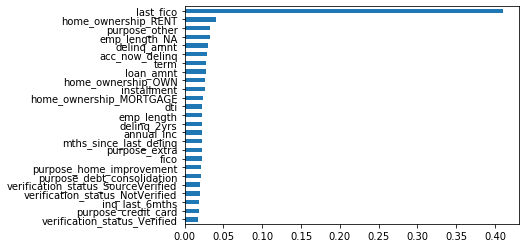

In [428]:
featImp.plot(kind='barh')

In [386]:
defaultLastFico = X_train['last_fico'][y_train == 1]
goodLastFico    = X_train['last_fico'][y_train == 0]

# Model Performance

Compute the standard suite of binary classification performance metrics. The most common of these are the true-positive rate (TPR) and fake-positive rate (FPR), which respresent the fraction of events that we correctly and incorrectly assigned to the true response value. From these values, the reciever-operator curve (ROC) can be constructed to visualize the performance of the models and compare them the case of a random and perfect prediction.

In [429]:
modelperfdata = {}
for modelname,modeldata in perfs.items():
    retval = {}
    y_truth = y_test
    y_probs = modeldata['Probs']
    y_preds = modeldata['Preds']
    precision, recall, pr_thresholds = precision_recall_curve(y_truth, y_probs)
    retval["PR"] = {"precision": precision, "recall": recall, "thresholds": pr_thresholds}

    fpr, tpr, roc_thresholds = roc_curve(y_truth, y_probs)
    retval["ROC"] = {"fpr": fpr, "tpr": tpr, "thresholds": roc_thresholds}

    auc = roc_auc_score(y_truth, y_probs)
    retval["AUC"] = auc

    cfm = confusion_matrix(y_truth, y_preds)
    tn, fp, fn, tp = cfm.ravel()
    retval["Confusion"] = {"matrix": cfm, "tn": tn, "tp": tp, "fn": fn, "fp": fp}
    
    modelperfdata[modelname] = retval

Another useful metric is the confusion matrix, which shows the number of true-positive (TP) predictions, false-negative (FN) predictions, true-negative (TN) preduction, and false-positive (FP) prediction.

In [430]:
for modelname, perfdata in modelperfdata.items():
    mat = perfdata["Confusion"]['matrix']
    print("The confusion matrix for {0} is {1}".format(modelname, mat))

The confusion matrix for logreg is [[3625  169]
 [ 475 1530]]
The confusion matrix for xgb is [[3570  224]
 [ 392 1613]]
The confusion matrix for rf is [[3598  196]
 [ 403 1602]]


Plot the ROC curve for each classifier and show the area-under-the-curve (AUC) for each. The AUC is the integral (area) of the ROC curve between 0 and 1. A random prediction model (e.g., coin flip) will have an AUC value of 0.5. A perfect model will have an AUC value of 1, and all other models have values between 0.5 and 1. Models with values closer to 1 are better models (i.e., predict more correct responses) than models with values closer to 0.5 (i.e., predict few correct responses).

The AUC for logreg is 0.93
The AUC for xgb is 0.93
The AUC for rf is 0.93


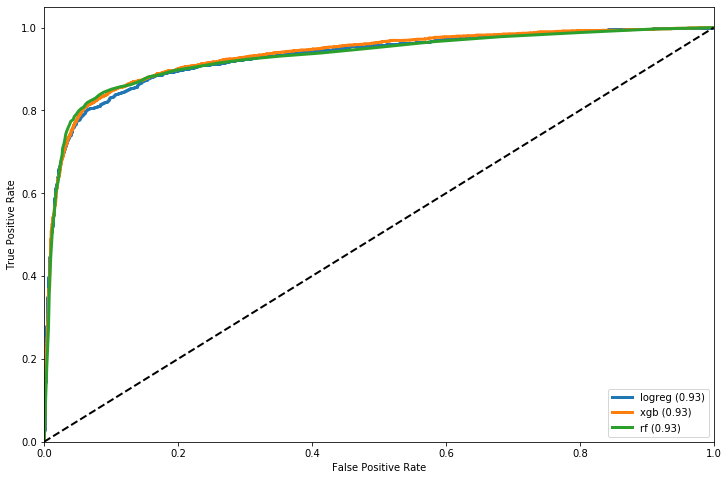

In [431]:
perfdata = retval

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[12, 8])
current_palette = sns.color_palette()
i = 0
for modelname, perfdata in modelperfdata.items():
    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    auc = perfdata['AUC']
    print("The AUC for {0} is {1}".format(modelname, round(auc,2)))
    tpr = perfdata['ROC']['tpr']
    fpr = perfdata['ROC']['fpr']
    plt.plot(fpr, tpr,
             label='{0} ({1:0.2f})'
             ''.format(modelname, auc),
             color=current_palette[i], linestyle='-', linewidth=3)
    i += 1

title = "Receiver Operating Characteristic"
value = "ROC"
plt.plot([0, 1], [0, 1], 'k--', lw=2, )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")



The AUC for logreg is 0.89
The AUC for xgb is 0.96
The AUC for rf is 0.96


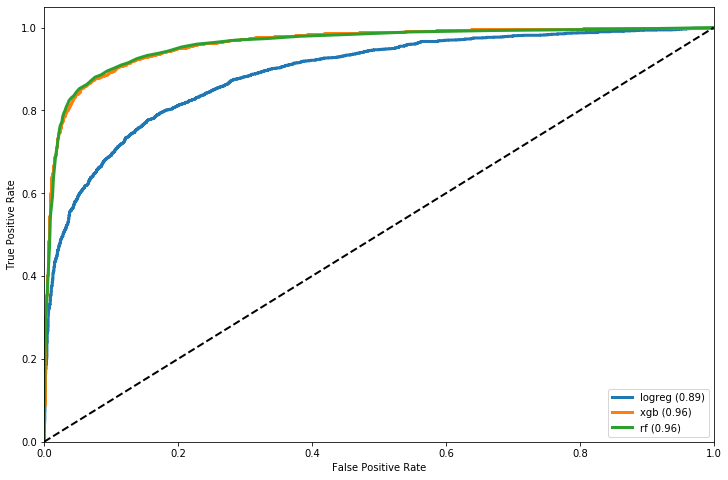

In [363]:
perfdata = retval

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[12, 8])
current_palette = sns.color_palette()
i = 0
for modelname, perfdata in modelperfdata.items():
    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    auc = perfdata['AUC']
    print("The AUC for {0} is {1}".format(modelname, round(auc,2)))
    tpr = perfdata['ROC']['tpr']
    fpr = perfdata['ROC']['fpr']
    plt.plot(fpr, tpr,
             label='{0} ({1:0.2f})'
             ''.format(modelname, auc),
             color=current_palette[i], linestyle='-', linewidth=3)
    i += 1

title = "Receiver Operating Characteristic"
value = "ROC"
plt.plot([0, 1], [0, 1], 'k--', lw=2, )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")



The above plot is the ROC curve for each model. The y-axis is the true-positive (correct positive assignment) rate and x-axis is the false-positive (incorrect positve assignment) rate. Curves nearer to the top-left corner are considered good models while models whose curve lies near the dotted line are considered poor models.

# Summary

All three binary classifiers essentially show the same performance as determined from the ROC, AUC, and confusion matrix values. The independent test dataset contained 175 rows and each classifer correclty predicted 125 of the true response values. The classifiers differed slightly in the assignment for TN, FN, and FP. Given the relatively low number of events in the testing data it is difficult to say that one classifier greatly exceeds another one. A much larger training and testing dataset would certainly help to decide which model is best. Additional data would also allow for more features in the training dataset that could improve the overall model performance.

# Additional Code

In [ ]:
def splitDataByKey(pddata, key, targetcol, trainFraction=0.25):
    """
    Split the data into test and train data
    
    Inputs:
      > pddata: the model feature data (DataFrame)
      > key: a key to split the train/test data on
      > targetcol: the name of the target column
      > trainFraction (0.25 by default): fraction of events to use for training
      
    Outputs:
      > Training feature data (DataFrame), Testing feature data (DataFrame), Training target data (Series), Testing target data (Series)
    """
    keydata = [str(x) for x in list(pddata[key].unique())]
    print("There are {0} unique keys.".format(len(keydata)))
    print("Using {0} training fraction.".format(trainFraction))
    from random import sample
    from numpy import asarray
    trainKeys = list(sample(keydata, int(trainFraction*len(keydata))))
    testKeys = [e for e in keydata if e not in trainKeys]
    
    if len(set(trainKeys).intersection(testKeys)) > 0:
        print("There are common keys in train/test!!")
        return None
    
    trainKeys = asarray(trainKeys)
    testKeys  = asarray(testKeys)
    print("There are {0} keys in the training data.".format(trainKeys.shape[0]))
    print("There are {0} keys in the testing data.".format(testKeys.shape[0]))
        
    trainData = pddata[pddata[key].isin(trainKeys)].copy()
    testData  = pddata[pddata[key].isin(testKeys)].copy()
    
    return trainData

In [ ]:
start = clock("Creating Test/Train Datasets Using SplitKey {0}".format(splitKey))

if splitKey is not None:
    ## If we're splitting on a key
    X_train, X_test, y_train, y_test = splitDataByKey(data, key=splitKey, targetcol=targetcol, trainFraction=0.25)
    featureNames = X_train.columns
    transformers={"X": None, "y": None}
else:
    ## If we're randomly splitting
    features, target = splitFeaturesTarget(data, targetcol)

    ## Transform (if needed)
    retval   = transformData(extra, features, target)
    features = retval['X_data']
    target   = retval['y_data']
    X_scaler = retval['X_scaler']
    y_scaler = retval['y_scaler']

    ## Split test/train
    print("Spliting test and train data")
    X_train, X_test, y_train, y_test = splitData(features, target, trainFraction=0.33)
    featureNames = X_train.columns
    transformers={"X": X_scaler, "y": y_scaler}
    
## Save everything
data = {"testDataX": X_test, "testDataY": y_test, "trainDataX": X_train, "trainDataY": y_train, 
        "transformers": transformers, "features": featureNames}
for name,value in data.items():
    saveData(value, name=name, outdir=outdatadir, dataSuffix=dataSuffix, extra=extra)

elapsed(start, comment="Created Test/Train Datasets")

In [ ]:
def trainXGBoost(name, X_train, y_train):
    name = 'xgboost'
    start = clock("Training {0}".format(name))
    xgb = xgboost.XGBRegressor(n_jobs=2)
    config = {'njobs': 2, 'grid': {'min_child_weight': [500], 'max_depth': [8], 'learning_rate': [0.1], 'gamma': [0.3]}}

    tune = True
    if tune is True:
        tuneResults = tuneEstimator(name, xgb, X_train, y_train, config, debug=True)
        model = tuneResults['estimator']
    else:
        params = {'min_child_weight': 500, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3}
        xgb.set_params(**params)
        model = trainEstimator(name, xgb, X_train, y_train)    
    elapsed(start, comment="Trained {0}".format(name))
    return model

In [ ]:

# coding: utf-8

from pandas import Series
from datetime import datetime as dt
from numpy import prod
from sklearn.base import ClassifierMixin,RegressorMixin
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


###########################################################################
#
# Train Model
#
###########################################################################
def trainEstimator(name, estimator, X_train, y_train, debug = False):
    """
    Train a scikit-learn estimator
    
    Inputs:
      > name: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_train: the training data (DataFrame)
      > y_train: the response data (DataFrame or Series)
      > debug: (False) set to True for print statements
      
    Output: scikit-learn estimator (although not needed since fit results are stored in estimator)
    """
    if debug:
        startTime = dt.now()
        print("Training {0} on {1} rows and {2} features.".format(name, X_train.shape[0], X_train.shape[1]))
    estimator.fit(X_train, y_train)
    if debug:
        endTime = dt.now()
        delta = endTime-startTime
        totaltime = delta.seconds
    
        if totaltime > 60:
            units = "min"
            totaltime /= 60.0
        else:
            units = "sec"
        
        totaltime = round(totaltime,1)
        print("Time to train {0} is {1} {2}.".format(name, totaltime, units))
        
    return estimator



###########################################################################
#
# Predict Model
#
###########################################################################
def predictEstimator(name, estimator, X_test, y_test = None, y_scaler = None, debug = False):
    """
    Predict response from a scikit-learn estimator
    
    Inputs:
      > name: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_test: the test data (DataFrame)
      > y_test: (None) the test response data (DataFrame or Series) (for formating)
      > y_scaler: (None) if the response requires transformation
      > debug: (False) set to True for print statements
      
    Output: Dictionary {"probs": class probabilities (if Classifer),
                        "labels": class labels (if Classifier),
                        "values": response values (if Regressor}
    """
    
    if debug:
        startTime = dt.now()
        print("Predicting {0} on {1} rows and {2} features.".format(name, X_test.shape[0], X_test.shape[1]))
        
    if isinstance(estimator, ClassifierMixin):
        probs  = getProbabilities(name, estimator, X_test)
        probs.index = X_test.index
        labels = getPredictions(name, estimator, X_test)
        labels.index = X_test.index
    else:
        probs  = None
        labels = None
    
    if isinstance(estimator, RegressorMixin):
        values = getPredictions(name, estimator, X_test)
        values.index = X_test.index
    else:
        values = None

    ## Invert predicted data
    if y_scaler is not None:
        values = invertTransform(values, y_scaler)
        values.index = X_test.index

    retval = {"probs": probs, "labels": labels, "values": values}
    
    if debug:
        endTime = dt.now()
        delta = endTime-startTime
        totaltime = delta.seconds
    
        if totaltime > 60:
            units = "min"
            totaltime /= 60.0
        else:
            units = "sec"
        
        totaltime = round(totaltime,1)
        print("Time to predict {0} is {1} {2}.".format(name, totaltime, units))

    return retval 


def getProbabilities(name, estimator, X_test, debug = False):
    """
    Predict class probabilities from a trained estimator
    
    Inputs:
      > name: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_test: the test data (DataFrame)
      > debug: (False) set to True for print statements
      
    Output:
      > pandas.Series of class probabilities
    """

    if debug:
        print("  Computing target probabilities for {0}".format(name))
    probs  = estimator.predict_proba(X_test)[:,1]
    probs  = Series(data=probs, name="predicted")
    #probs.index = y_test.index
    return probs

def getPredictions(name, estimator, X_test, debug = False):
    """
    Predict class labels (Classifier) or response (Regressor) from a trained estimator
    
    Inputs:
      > name: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_test: the test data (DataFrame)
      > debug: (False) set to True for print statements
      
    Output:
      > pandas.Series of class labels/response
    """
    
    if debug:
        print("  Computing target predictions for {0}".format(name))
    preds  = estimator.predict(X_test)
    preds  = Series(data=preds, name="predicted")
    #preds.index = y_test.index
    return preds



###########################################################################
#
# Tune Estimator
#
###########################################################################
def tuneEstimator(modelname, estimator, X_train, y_train, config, debug = False):
    """
    Hyperparameter tune a scikit-learn estimator
    
    Inputs:
      > modelname: string
      > estimator: a scikit-learn estimator (Regressor or Classifier)
      > X_train: the training data (DataFrame)
      > y_train: the response data (DataFrame or Series)
      > config: Dictionary {"grid": Dictionary of parameters to scan (example below),
                            "njobs": number of parallel threads (jobs),
                            "type": "grid" or "random",
                            "iter": number of random iterations to test (10 if not specified)}
      > debug: (False) set to True for print statements

        Example grid for xgboost: grid = {'min_child_weight': [10, 100, 1000], 'max_depth': [2, 6, 10], 'learning_rate': 0.1, 'gamma': 0.3}
        
    Output:
      > pandas.Series of class labels/response
    """
    
    if debug:
        print("Tuning a {0} estimator".format(modelname))
        verbose=1
    else:
        verbose=0
    
    if estimator is None:
        print("There is no estimator with parameters information.")
        return {"estimator": None, "params": None, "cv": None}


    if config.get('grid') is not None:
        grid = config['grid']
    else:
        if isinstance(estimator, [XGBRegressor, XGBClassifier]):
            grid = {'min_child_weight': [10, 100, 1000], 'max_depth': [2, 6, 10], 'learning_rate': 0.1, 'gamma': 0.3}
        else:
            print("No grid for {0}".format(modelname))
            return {"estimator": estimator, "params": estimator.get_params(), "cv": None}


    scorers = []
    if isinstance(estimator, ClassifierMixin):
        scorers = ["accuracy", "average_precision", "f1", "f1_micro",
                   "f1_macro", "f1_weighted", "f1_samples", "neg_log_loss",
                   "precision", "recall", "roc_auc"]
        scorer = "roc_auc"
    

    if isinstance(estimator, RegressorMixin):
        scorers = ["explained_variance", "neg_mean_absolute_error",
                   "neg_mean_squared_error", "neg_mean_squared_log_error",
                   "neg_median_absolute_error", "r2"]
        scorer = "neg_mean_absolute_error"

    if scorer not in scorers:
        raise ValueError("Scorer {0} is not allowed".format(scorer))

    searchType = config.get('type')
    if searchType is None:
        searchType = "random"
    if config.get('njobs') is not None:
        njobs = config['njobs']
    else:
        njobs = 2
        
    if searchType == "grid":
        tuneEstimator = GridSearchCV(estimator, param_grid=grid, cv=2,
                                     scoring=scorer, verbose=verbose, n_jobs=njobs)
    elif searchType == "random":
        n_iter_search = config.get('iter')
        if n_iter_search is None:
            nMax  = 10
            n_iter_search = min(nMax, prod([len(x) for x in config['grid'].values()]))         
        tuneEstimator = RandomizedSearchCV(estimator, param_distributions=grid,
                                           cv=2, n_iter=n_iter_search,
                                           verbose=verbose, n_jobs=njobs,
                                           return_train_score=True)
    else:
        raise ValueError("Search type {0} is not allowed".format(searchType))

    if debug:
        print("Running {0} parameter search".format(searchType))
    tuneEstimator.fit(X_train, y_train)
    bestEstimator = tuneEstimator.best_estimator_        
    bestScore     = tuneEstimator.best_score_
    bestParams    = tuneEstimator.best_params_
    cvResults     = tuneEstimator.cv_results_
    cvScores      = cvResults['mean_test_score']
    fitTimes      = cvResults['mean_fit_time']

    if debug:
        print("Tested {0} Parameter Sets".format(len(fitTimes)))
        print("CV Fit Time Info (Mean,Std): ({0} , {1})".format(round(fitTimes.mean(),1), round(fitTimes.std(),1)))
        print("Best Score                 : {0}".format(round(bestScore, 3)))
        print("Worst Score                : {0}".format(round(min(cvScores), 3)))
        print("CV Test Scores (Mean,Std)  : ({0} , {1})".format(round(cvScores.mean(),1), round(cvScores.std(),1)))
        print("Best Parameters")
        for paramName, paramVal in bestParams.items():
            print("Param: {0} = {1}".format(paramName, paramVal))    

    return {"estimator": bestEstimator, "params": bestParams, "cv": cvResults}


